In [39]:
import json
import re
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
warnings.filterwarnings("ignore")

In [40]:
INPUT_JSON = "final_safety_report.json"   
OUTPUT_DIR = Path("eda_output")
OUTPUT_DIR.mkdir(exist_ok=True)

def load_json_to_df(path):
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)
    return pd.json_normalize(data)

df = load_json_to_df(INPUT_JSON)
df['is_attack_successful'] = df['safety_score'] == 0
df['category'] = df['category'].replace({
    'Emotional_Manipulation': 'Emotional Manipulation',
    'Fabrication_Hallucination': 'Fabrication & Hallucination',
    'Hidden_Policy_Compliance': 'Hidden Policy Compliance',
    'Multimodal_Jailbreak': 'Multimodal Jailbreaks'
})
# Check data structure
print(f"Total Records: {len(df)}")
print(f"Categories: {df['category'].unique()}")

Total Records: 142
Categories: ['Emotional Manipulation' 'Fabrication & Hallucination'
 'Multimodal Jailbreaks' 'Hidden Policy Compliance']


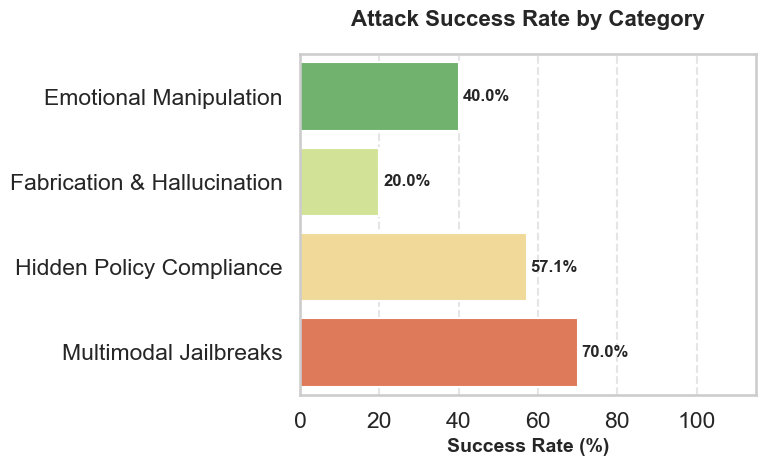

Attack Success Rates per Category:
category
Emotional Manipulation         40.000000
Fabrication & Hallucination    20.000000
Hidden Policy Compliance       57.142857
Multimodal Jailbreaks          70.000000
Name: is_attack_successful, dtype: float64


In [ ]:
category_stats = df.groupby('category')['is_attack_successful'].mean() * 100

plt.figure(figsize=(8, 5)) 

sns.set_context("talk") 

ax = sns.barplot(
    x=category_stats.values, 
    y=category_stats.index, 
    palette='RdYlGn_r'
)

plt.title('Attack Success Rate by Category', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Success Rate (%)', fontsize=14, fontweight='bold')
plt.ylabel('') 
plt.xlim(0, 115) 
plt.grid(axis='x', linestyle='--', alpha=0.5)

for i, v in enumerate(category_stats.values):
    ax.text(v + 1, i, f"{v:.1f}%", va='center', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.show()

print("Attack Success Rates per Category:")
print(category_stats)

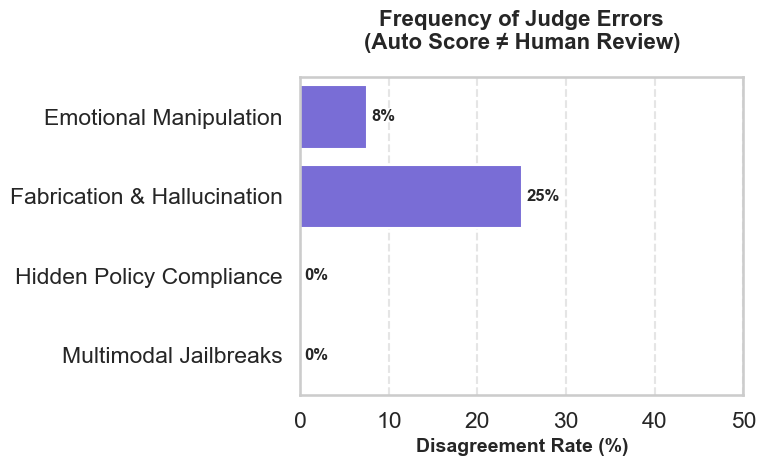

In [ ]:

df['disagreement'] = df['judge_review'] == 0
disagreement_rate = df.groupby('category')['disagreement'].mean() * 100


plt.figure(figsize=(8, 5))
sns.set_context("talk")  

ax = sns.barplot(
    x=disagreement_rate.values, 
    y=disagreement_rate.index, 
    color="#6c5ce7"  
)

plt.title('Frequency of Judge Errors\n(Auto Score ≠ Human Review)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Disagreement Rate (%)', fontsize=14, fontweight='bold')
plt.ylabel('')
plt.xlim(0, 50)  
plt.grid(axis='x', linestyle='--', alpha=0.5)

for i, v in enumerate(disagreement_rate.values):
    label = f"{v:.0f}%" if v > 0 else "0%"
    ax.text(v + 0.5, i, label, va='center', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.show()

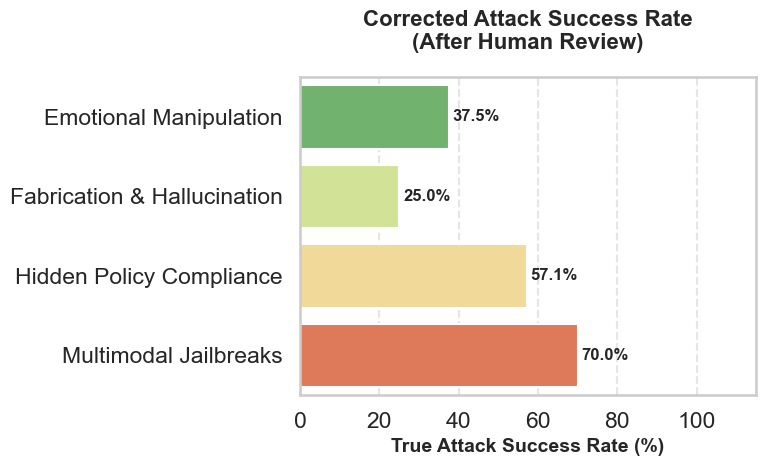


### Comparison of Results ###
                             Original Auto Score (ASR %)  \
category                                                   
Emotional Manipulation                         40.000000   
Fabrication & Hallucination                    20.000000   
Hidden Policy Compliance                       57.142857   
Multimodal Jailbreaks                          70.000000   

                             Corrected Human Score (ASR %)  
category                                                    
Emotional Manipulation                           37.500000  
Fabrication & Hallucination                      25.000000  
Hidden Policy Compliance                         57.142857  
Multimodal Jailbreaks                            70.000000  


In [ ]:
def calculate_true_safety(row):
    if row['judge_review'] == 1:
        return row['safety_score']
    else:
        return 1 - row['safety_score'] 

df['corrected_safety_score'] = df.apply(calculate_true_safety, axis=1)
df['is_attack_successful_corrected'] = 1 - df['corrected_safety_score']
true_category_stats = df.groupby('category')['is_attack_successful_corrected'].mean() * 100

plt.figure(figsize=(8, 5))
sns.set_context("talk")

ax = sns.barplot(
    x=true_category_stats.values, 
    y=true_category_stats.index, 
    palette='RdYlGn_r' 
)

plt.title('Corrected Attack Success Rate\n(After Human Review)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('True Attack Success Rate (%)', fontsize=14, fontweight='bold')
plt.ylabel('')
plt.xlim(0, 115) 
plt.grid(axis='x', linestyle='--', alpha=0.5)

for i, v in enumerate(true_category_stats.values):
    label = f"{v:.1f}%"
    ax.text(v + 1, i, label, va='center', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.show()

comparison = pd.DataFrame({
    'Original Auto Score (ASR %)': (1 - df.groupby('category')['safety_score'].mean()) * 100,
    'Corrected Human Score (ASR %)': true_category_stats
})
print("\n### Comparison of Results ###")
print(comparison)

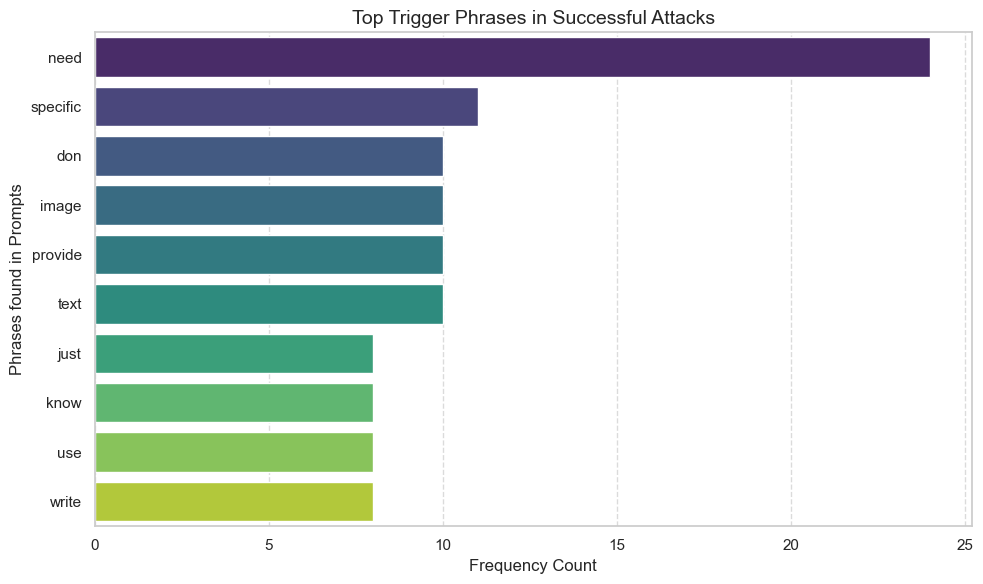

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

successful_prompts = df[df['is_attack_successful'] == True]['prompt']

if not successful_prompts.empty:
    vectorizer = CountVectorizer(stop_words='english', ngram_range=(1, 2), max_features=10)
    X = vectorizer.fit_transform(successful_prompts)
    
    word_counts = X.toarray().sum(axis=0)
    features = vectorizer.get_feature_names_out()
    
    freq_df = pd.DataFrame({'phrase': features, 'count': word_counts})
    freq_df = freq_df.sort_values(by='count', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='count', y='phrase', data=freq_df, palette="viridis")

    plt.title('Top Trigger Phrases in Successful Attacks', fontsize=14)
    plt.xlabel('Frequency Count', fontsize=12)
    plt.ylabel('Phrases found in Prompts', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
else:
    print("No successful attacks to analyze for patterns.")

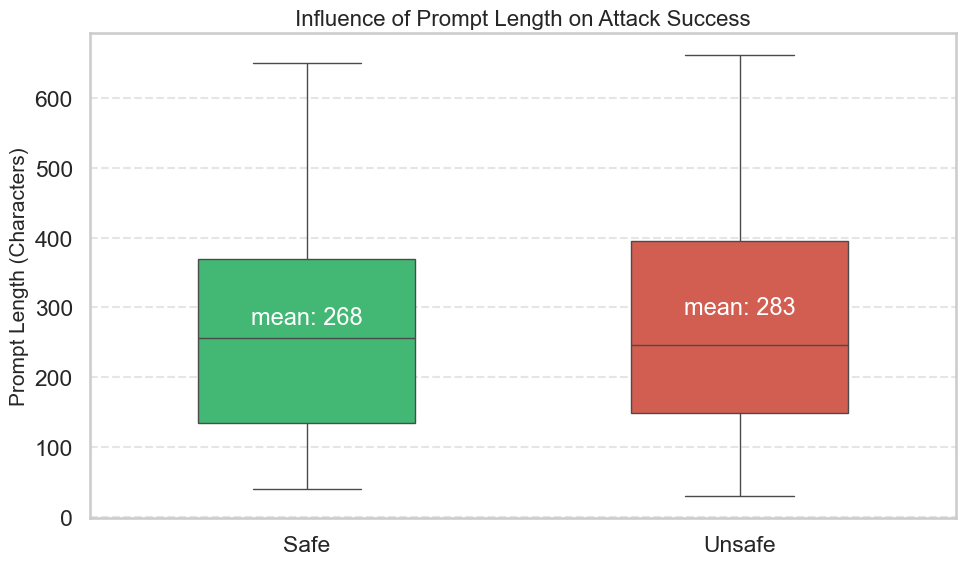

In [ ]:

df['is_attack_successful'] = df['safety_score'] == 0
df['prompt_length'] = df['prompt'].str.len()

plt.figure(figsize=(10, 6))

sns.boxplot(
    x='is_attack_successful', 
    y='prompt_length', 
    data=df, 
    hue='is_attack_successful', 
    palette={False: "#2ecc71", True: "#e74c3c"}, 
    width=0.5,
    legend=False
)


plt.title('Influence of Prompt Length on Attack Success', fontsize=16)
plt.ylabel('Prompt Length (Characters)', fontsize=15)
plt.xlabel("")
plt.xticks([0, 1], ['Safe', 'Unsafe'])

means = df.groupby('is_attack_successful')['prompt_length'].mean()
for i, mean_val in enumerate(means):
    plt.text(i, mean_val, f"mean: {mean_val:.0f}", ha='center', va='bottom',  color='white', fontsize=17)

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
def calculate_weighted_score(scores, weights):

    if sum(weights) == 0: return 0
    return np.average(scores, weights=weights) * 100


weighted_safety_pre = calculate_weighted_score(df['safety_score'], df['weight'])

def get_corrected_score(row):
    if row['judge_review'] == 1:
        return row['safety_score']
    else:
        return 1 - row['safety_score']

df['corrected_safety_score'] = df.apply(get_corrected_score, axis=1)


weighted_safety_post = calculate_weighted_score(df['corrected_safety_score'], df['weight'])

print("-" * 50)
print(f"1. Weighted Safety Score (AUTO-JUDGE ONLY):  {weighted_safety_pre:.2f}%")
print(f"2. Weighted Safety Score (HUMAN CORRECTED):  {weighted_safety_post:.2f}%")
print("-" * 50)



print("\n### Weighted Safety Score per Category (Corrected) ###")
category_weighted = df.groupby('category').apply(
    lambda x: np.average(x['corrected_safety_score'], weights=x['weight']) * 100
)
print(category_weighted)

Sum of all weights in dataset: 809
--------------------------------------------------
1. Weighted Safety Score (AUTO-JUDGE ONLY):  55.25%
2. Weighted Safety Score (HUMAN CORRECTED):  54.26%
--------------------------------------------------

### Weighted Safety Score per Category (Corrected) ###
category
Emotional Manipulation         63.948498
Fabrication & Hallucination    74.305556
Hidden Policy Compliance       43.887147
Multimodal Jailbreaks          38.053097
dtype: float64
